# Импорт библиотек

In [1]:
# установим недостающие пакеты
!pip install pysrt
!pip install spacy

import os
import numpy as np
import pandas as pd
import pysrt
import spacy
import re
from joblib import dump, load
import matplotlib.pyplot as plt

# импортируем библиотеки sklearn
from sklearn.datasets import load_files  
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer

In [2]:
RANDOM_SEED = 666

# Загрузка данных

In [3]:
df = pd.read_excel('data/movies_labels.xlsx', index_col='id')

In [4]:
df['Level'].unique()

array(['B1', 'B2', 'A2/A2+', 'C1', 'B1, B2', 'A2/A2+, B1', 'A2'],
      dtype=object)

# Словарь для замены меток классов

In [5]:
label_dict = {'A2': 1,
              'A2/A2+': 1,
              'B1': 2,
              'A2/A2+, B1': 2,
              'B2': 3,
              'B1, B2': 3,
              'C1': 4}

In [6]:
df = df.replace(label_dict)

# Удалим дубликаты

In [7]:
df = df.drop_duplicates()

# Работаем с субтитрами

In [8]:
films_name = os.listdir(path='./data/Subtitles')

In [9]:
films_filtr = set(films_name) & set(df['Movie'] + '.srt')

# Загрузка словаря oxford

In [10]:
oxford = load_files('data/Oxford/Classic Oxford/', shuffle=False, encoding='utf-8-sig')

# Создание функций для работы с субтитрами

In [11]:
HTML = r'<.*?>'
TAG = r'{.*?}'
COMMENTS = r'[\(\[][A-Za-z ]+[\)\]]'
LETTERS = r'[^a-zA-Z\.,!? ]'
SPACES = r'([ ])\1+'
DOTS = r'[\.]+'

Функция для очистки субтитров

In [12]:
def clean_subs(subs):
    subs = subs[1:] # Удаление первого рекламного субтитра
    txt = re.sub(HTML, ' ', subs.text) # Замена HTML-тегов на пробел
    txt = re.sub(COMMENTS, ' ', txt) # Замена комментариев в скобках на пробел
    txt = re.sub(LETTERS, ' ', txt) # Замена всех символов, кроме букв, на пробел
    txt = re.sub(DOTS, r'.', txt) # Замена многоточия на точку
    txt = re.sub(SPACES, r'\1', txt) # Замена повторяющихся пробелов на один пробел
    txt = re.sub('www', '', txt) # Замена оставшихся www на пустую строку
    txt = txt.lstrip() # Обрезка пробелов слева
    txt = txt.encode('ascii', 'ignore').decode() # Удаление всех символов, не являющихся ASCII-символами   
    txt = txt.lower() # Приведение текста к нижнему регистру
    return txt

In [13]:
def lemma_count(lemmas, oxf, cat):
    func_dict = {'A1': 0,
                 'A2': 1,
                 'B1': 2,
                 'B2': 3,
                 'C1': 4}
    level = func_dict[cat]
    oxf_word_list = oxf[level].split()
    words = [lemma for lemma in lemmas if lemma in oxf_word_list]

    return len(set(words))

Функция для подсчета пунктуации в тексте

In [14]:
def count_punctuation(text):
    if isinstance(text, float) or pd.isna(text):
        return 0
    punctuation = ['.', ',', '!', '?', ';', ':']
    count = 0
    for char in text:
        if char in punctuation:
            count += 1
    return count

# Обработка субтитров

In [15]:
for film in films_filtr:
    try: 
        subs = pysrt.open(f'data/Subtitles/{film}')
    except:
        subs = pysrt.open(f'data/Subtitles/{film}', encoding='iso-8859-1')
        
    # Очистка текста субтитров
    cln_subs = clean_subs(subs)
    
    # Запись очищенного текста субтитров в DataFrame
    df.loc[df['Movie'] == film[:-4], 'subs'] = cln_subs
    
    # Лемматизация текста субтитров
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(cln_subs)
    lemma_list = [token.lemma_ for token in doc]
    
    # Запись количества уникальных лемм для каждого уровня в DataFrame
    for lvl in ['A1', 'A2', 'B1', 'B2', 'C1']:
        df.loc[df['Movie'] == film[:-4], lvl+'_lemma_cnt'] = lemma_count(lemma_list, oxford.data, lvl)

Признак с пунктуацией

In [16]:
df['punctuation_cnt'] = df['subs'].apply(count_punctuation)

Фильтрация

In [17]:
df.dropna(inplace=True)

# Разделение на обучающую и тестовую выборки

In [18]:
df_train, df_test = train_test_split(df, random_state=RANDOM_SEED, test_size=.2, stratify=df['Level'])

In [19]:
X_train = df_train.drop(['Level', 'Movie'], axis=1)

In [20]:
y_train = df_train['Level']

In [21]:
X_test = df_test.drop(['Level', 'Movie'], axis=1)

In [22]:
y_test = df_test['Level']

# Векторизация текстовых данных

In [23]:
vect = CountVectorizer(min_df=4).fit(X_train['subs'])

In [24]:
X_train_vect = vect.transform(X_train['subs'])

In [25]:
X_test_vect = vect.transform(X_test['subs'])

In [26]:
feature_names = vect.get_feature_names_out()

In [27]:
print('Количество признаков: {}'.format(len(feature_names)))
print('Первые 20 признаков:\n{}'.format(feature_names[:20]))
print('Признаки с 2000 по 2060:\n{}'.format(feature_names[2000:2060]))
print('Каждый 100-й признак:\n{}'.format(feature_names[::100]))

Количество признаков: 6155
Первые 20 признаков:
['aah' 'ab' 'abandon' 'abandoned' 'abilities' 'ability' 'able' 'aboard'
 'about' 'above' 'abroad' 'absence' 'absolute' 'absolutely' 'absorbed'
 'absurd' 'abuse' 'academic' 'academy' 'accent']
Признаки с 2000 по 2060:
['fetch' 'few' 'fi' 'fianc' 'fiction' 'field' 'fields' 'fifteen' 'fifth'
 'fifty' 'fight' 'fighter' 'fighting' 'fights' 'figure' 'figured'
 'figures' 'file' 'filed' 'files' 'filing' 'fill' 'filled' 'filling'
 'film' 'films' 'filthy' 'final' 'finally' 'finals' 'financial' 'find'
 'finding' 'finds' 'fine' 'finest' 'finger' 'fingers' 'finish' 'finished'
 'finishing' 'fire' 'fired' 'fireplace' 'fires' 'fireworks' 'firing'
 'firm' 'first' 'fish' 'fishing' 'fist' 'fit' 'fits' 'fitting' 'five'
 'fix' 'fixed' 'fixing' 'flag']
Каждый 100-й признак:
['aah' 'aggressive' 'answers' 'association' 'banner' 'benefits' 'bong'
 'brother' 'canada' 'change' 'claiming' 'committee' 'cooperate' 'cubs'
 'deepest' 'differences' 'dorm' 'east' 'environ

# Функция для отображения матрицы ошибок

In [28]:
def plot_confusion_matrix(y_test, y_preds, classes, cmap='Blues'):
    fig, ax = plt.subplots(figsize=(16, 10))
    cm = confusion_matrix(y_test, y_preds)
    cmp = ConfusionMatrixDisplay(cm, display_labels=classes)
    cmp.plot(ax=ax, cmap=cmap)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix')
    plt.show()

# Построение модели с использованием мультиномиального наивного Байеса

In [29]:
model = MultinomialNB()

In [30]:
model.fit(X_train_vect, y_train)

MultinomialNB()

In [31]:
y_preds = model.predict(X_test_vect)

# Оценка качества модели

In [32]:
f1 = f1_score(y_test, y_preds, average='weighted')

In [33]:
print('F1 Score:', f1)
print(classification_report(y_test, y_preds))

F1 Score: 0.37107438016528926
              precision    recall  f1-score   support

           1       1.00      0.20      0.33         5
           2       0.43      0.75      0.55         8
           3       0.29      0.25      0.27         8
           4       0.00      0.00      0.00         1

    accuracy                           0.41        22
   macro avg       0.43      0.30      0.29        22
weighted avg       0.49      0.41      0.37        22



D:\Soft\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Soft\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Soft\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
unique_classes = np.unique(np.concatenate((y_test, y_preds)))

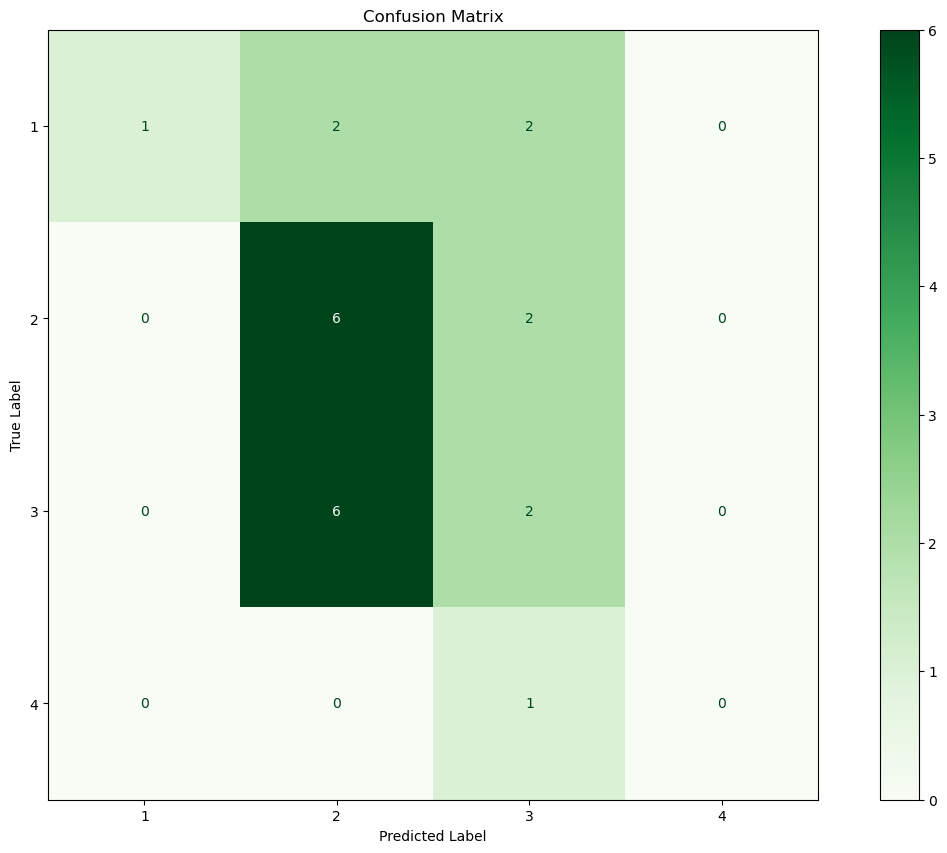

In [35]:
plot_confusion_matrix(y_test, y_preds, unique_classes, cmap='Greens')

# Обучение модели на полном наборе данных и сохранение модели и данных

In [36]:
X_full = pd.concat([X_train, X_test])

In [37]:
y_full = pd.concat([y_train, y_test])

In [38]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', vect, 'subs'),
        ('num', 'passthrough', ['A1_lemma_cnt', 'A2_lemma_cnt', 'B1_lemma_cnt', 'B2_lemma_cnt', 'C1_lemma_cnt', 'punctuation_cnt'])
    ])

In [39]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

In [40]:
param_grid = {
    'preprocessor__text__min_df': [2, 3, 4],
    'classifier__alpha': [0.1, 0.5, 1.0]
}

In [41]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_weighted')

In [42]:
grid.fit(X_full, y_full)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('text',
                                                                         CountVectorizer(min_df=4),
                                                                         'subs'),
                                                                        ('num',
                                                                         'passthrough',
                                                                         ['A1_lemma_cnt',
                                                                          'A2_lemma_cnt',
                                                                          'B1_lemma_cnt',
                                                                          'B2_lemma_cnt',
                                                                          'C1_lemma_cnt',
                                            

In [43]:
print('Best Parameters:', grid.best_params_)
print('Best Score:', grid.best_score_)

Best Parameters: {'classifier__alpha': 0.5, 'preprocessor__text__min_df': 4}
Best Score: 0.4556825808473309


In [44]:
dump(grid, './models/model_bayesNB.joblib')
dump(oxford.data, './oxford/classic_oxford.joblib')

['./oxford/classic_oxford.joblib']